In [108]:
import seaborn as sns
sns.set_style(rc={'font.family': ['sans-serif'],'axis.labelsize': 20})
sns.set_context("notebook")

# Modelling the pulsar population with a Gaussian mixture model

In this script I will describe some work to cluster the pulsar population using Gaussian mixture models. 

## Setup 

Firstly we need to get hold of the data, this comes courtesy of the [ANTF pulsar catalouge](http://www.atnf.csiro.au/people/pulsar/psrcat/). Here is a make file to download and extract the data we need:

In [109]:
%%writefile Makefile

DOWNLOADED = psrcat_pkg.tar
ATNF_DATABASE = psrcat_tar
DATA_FILE = ATNF_data_file.txt
PSRCAT_FILE_PATH = /home/greg/Neutron_star_modelling/MSP_NormalPulsars_PopulationStudy/psrcat_tar/psrcat.db

all:  $(DATA_FILE) $(ATNF_DATABASE)

.PHONY: clean

$(ATNF_DATABASE): 
	wget http://www.atnf.csiro.au/people/pulsar/psrcat/downloads/psrcat_pkg.tar.gz
	gunzip psrcat_pkg.tar.gz
	tar -xvf psrcat_pkg.tar
	cd psrcat_tar && ls && . makeit

$(DATA_FILE):
	export PSRCAT_FILE=${PSRCAT_FILE_PATH}; \
		./psrcat_tar/psrcat -c "name F0 F1 F2 BINARY TYPE W10" -nonumber -o short > ${DATA_FILE}

clean:
	rm -f ${DOWNLOADED}

Overwriting Makefile


In [110]:
! make

make: Nothing to be done for `all'.


This will have created a file `ATNF_data_file.txt` in the local directory which looks like:

In [111]:
! head ATNF_data_file.txt

---------------------------------------------------------------------------------------------------
NAME                    F0          F1          F2  BINARY    PSR                             W10  
                      (Hz)      (s^-2)      (s^-3)  (type)    TYPE                           (ms)  
---------------------------------------------------------------------------------------------------
J0006+1834        1.441446  -4.357e-15           *  *         *                           195.000  
J0007+7303        3.165827  -3.612e-12   4.100e-23  *         NRAD                              *  
B0011+47          0.805997  -3.667e-16   7.300e-28  *         *                           142.500  
J0023+0923      327.868852           *           *  BT        HE                                *  
B0021-72C       173.708219   1.504e-15           *  *         *                                 *  
B0021-72D       186.651670   1.195e-16           *  *         *                                 *  


For the time being, we can just import the data which we are interested in, namely the frequency 'F0'. 
We now import it, sanitize it and plot a histogram to motivate the rest of the work

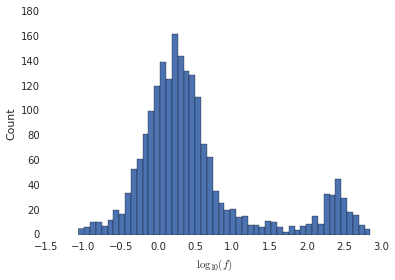

In [112]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

DATA_FILE = "ATNF_data_file.txt"

data = np.genfromtxt(DATA_FILE, skip_header=4, skip_footer=1, dtype=None)
F0 = np.genfromtxt(data[:, 1])
F1 = np.genfromtxt(data[:, 2])
F0 = F0[np.isfinite(F0)]
F1 = F1[np.isfinite(F0)]
F0 = F0[np.isfinite(F1)]
F1 = F1[np.isfinite(F1)]

data = np.log10(F0)

out = plt.hist(data, bins=50)
plt.xlabel("$\log_{10}(f)$")
plt.ylabel("Count")
plt.show()


As you can appreciate there are two distinct populations of pulsars: the larger regular population and the smaller
millisecond pulsars which have significantly larger spin frequencies. We will now apply a Gaussian mixture model to
learn about the underlying populations

## Gaussian Mixture model

With `skikit-learn` this is an incredibly simple problem. We simply create a model which we restrict to having two components. Then fit the model to the data, this is using the Expectation maximisation method as [described in the docs](http://scikit-learn.org/stable/modules/mixture.html#gmm-classifier).

In [113]:
from sklearn.mixture import GMM

model = GMM(2)
model.fit(data)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=0.01)

### Checking the fit
To check the fit, let us plot the pdf of the model with the data

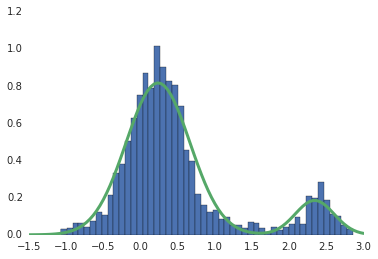

In [114]:
vals = np.linspace(-1.5, 3, 100)
logprobs, responcibility = model.score_samples(vals)
pdf = np.exp(logprobs)
plt.hist(data, bins=50, normed=True)
plt.plot(vals, pdf, lw=3)
plt.show()

This looks very promising, we can also extract the mean and standard deviations of the two Gaussian components in the mixture:

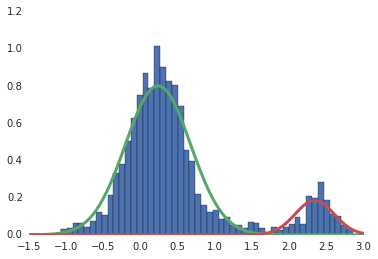

In [115]:
from scipy.stats import norm

[muA, muB] = model.means_
[sigmA, sigmaB] = np.sqrt(model.covars_)
[wA, wB] = model.weights_

plt.hist(data, bins=50, normed=True)
plt.plot(vals, wA*norm.pdf(vals, loc=muA, scale=sigmaA), lw=3)
plt.plot(vals, wB*norm.pdf(vals, loc=muB, scale=sigmaB), lw=3)
plt.show()


## Classifying the points

Finally we will plot the frequency and first derivative values is a so called "f-fdot" plot. 

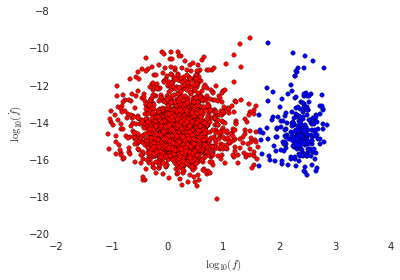

In [117]:
labels = model.predict(data)

ax = plt.subplot(111)
ax.scatter(np.log10(F0[labels==0]), np.log10(np.abs(F1[labels==0])), c="r")
ax.scatter(np.log10(F0[labels==1]), np.log10(np.abs(F1[labels==1])), c="b")
ax.set_xlabel("$\log_{10}(f)$")
ax.set_ylabel("$\log_{10}(\dot{f})$")
plt.show()

This nicely differentiates between the population of MSPs and normal radio pulsars without having to place a limit on $f$ by hand.